# Modules

In [1]:
%load_ext autoreload
%autoreload 2

import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr, wilcoxon

from pdathome.constants import global_constants as gc, mappings as mp
from pdathome.evaluation import plot_coefs, plot_n_subjects, calculate_pvalue, plot_significance

d_plot_params = {
    'font.family': 'serif',
    'font.size': 18,
    'axes.labelsize': 20,
    'axes.titlesize': 22,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14,
    'legend.title_fontsize': 16,
}

sns.set(rc=d_plot_params)
sns.set_theme(style='white', rc=d_plot_params)

# Constants

In [2]:
l_segment_cats = ['short', 'moderately_long', 'long', 'very_long']

# Load

In [3]:
d_performance = {
    gc.descriptives.PARKINSONS_DISEASE: {},
    gc.descriptives.CONTROLS: {}
}
for subject in gc.participant_ids.L_PD_IDS + gc.participant_ids.L_HC_IDS:
    if subject in gc.participant_ids.L_PD_IDS:
        population = gc.descriptives.PARKINSONS_DISEASE
    else:
        population = gc.descriptives.CONTROLS

    with open(os.path.join(gc.paths.PATH_OUTPUT, 'classification_performance', 'arm_activity', f'{subject}.json'), 'r') as f:
        d_performance[population][subject] = json.load(f)

with open(os.path.join(gc.paths.PATH_OUTPUT, 'feature_coefficients', 'arm_activity', f'{gc.classifiers.LOGISTIC_REGRESSION}.json')) as f:
    coefs_lr = json.load(f)

with open(os.path.join(gc.paths.PATH_OUTPUT, 'feature_coefficients', 'arm_activity', f'{gc.classifiers.RANDOM_FOREST}.json')) as f:
    coefs_rf = json.load(f)

coefs_lr = {
    (f"accelerometer_{k[:-4]}" if k.endswith("_acc") else k): v 
    for k, v in coefs_lr.items() if k != 'angle_perc_power'
}

coefs_rf = {
    (f"accelerometer_{k[:-4]}" if k.endswith("_acc") else k): v 
    for k, v in coefs_rf.items() if k != 'angle_perc_power'
}

# Figures and tables

#### Feature coefficients

Logistic regression coefficients

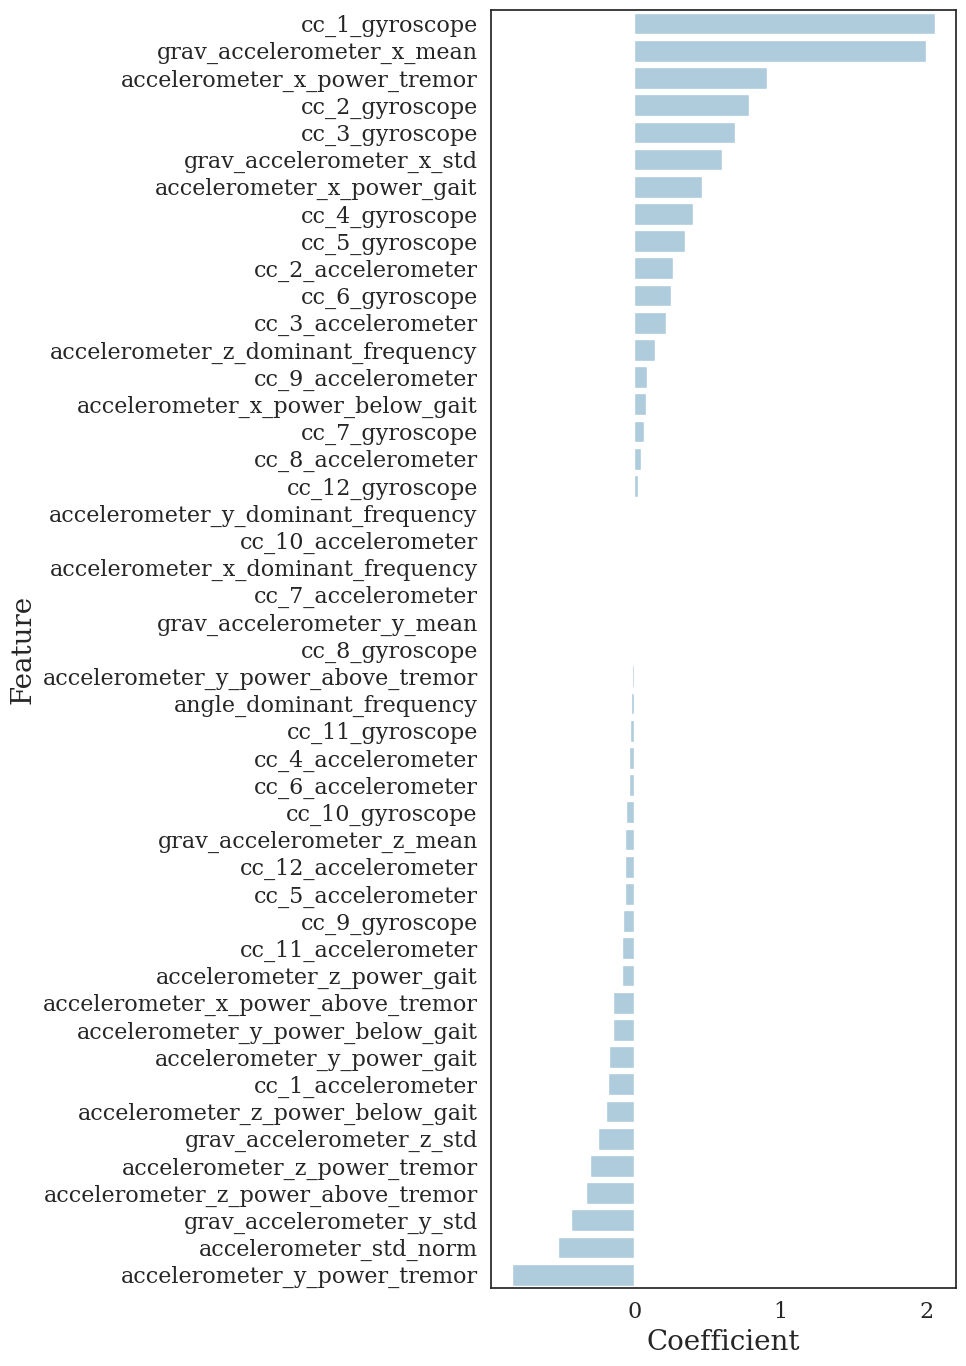

In [4]:
plot_coefs(d_coefs=coefs_lr, classifier=gc.classifiers.LOGISTIC_REGRESSION, figsize=(10,14))

Random forest impurity score

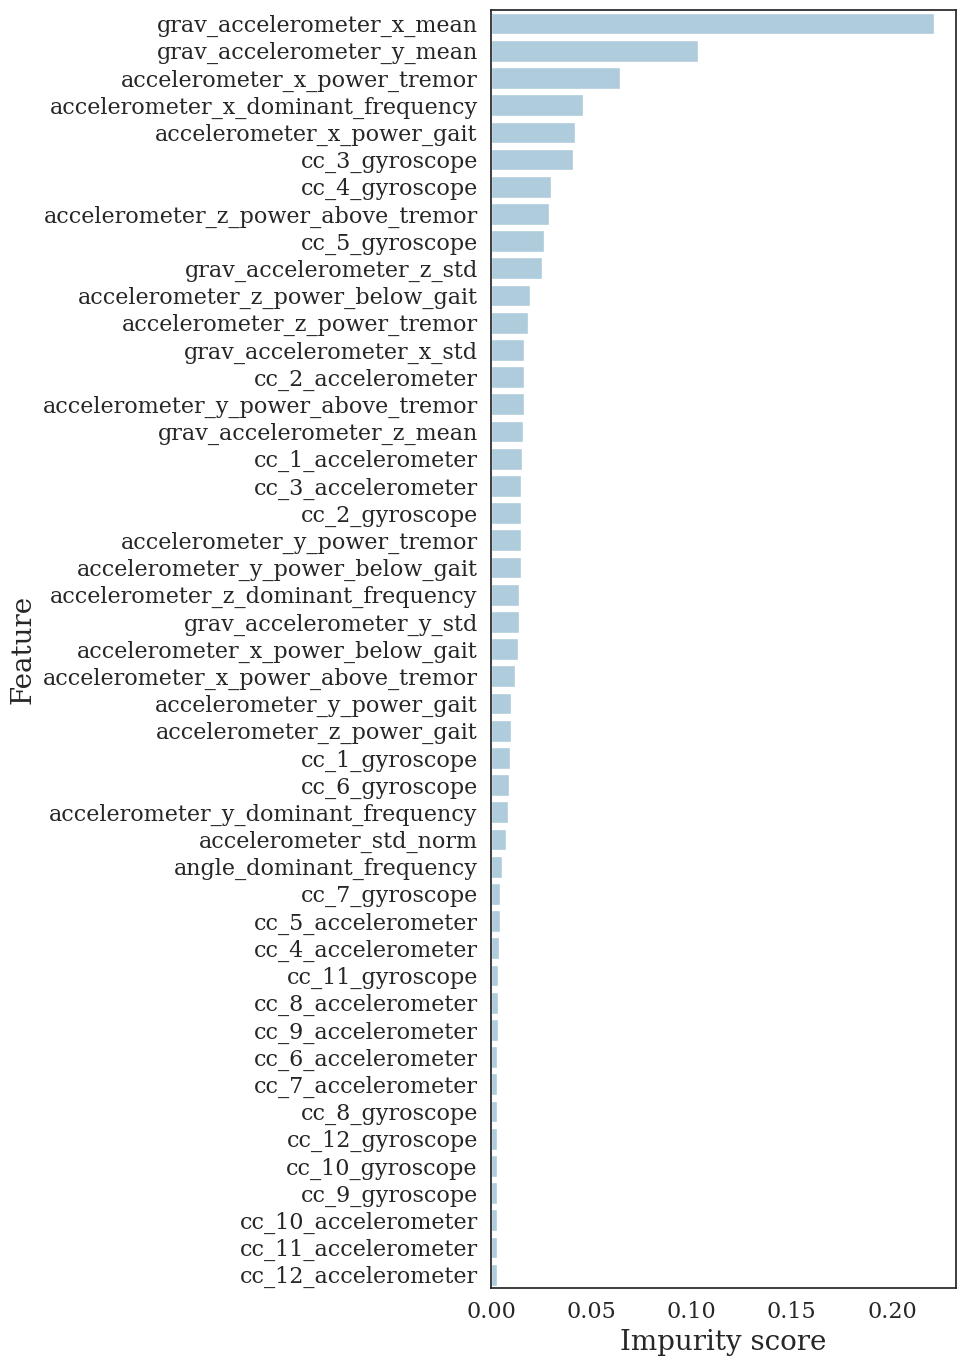

In [5]:
plot_coefs(d_coefs=coefs_rf, classifier=gc.classifiers.RANDOM_FOREST, figsize=(10,14))

# Dataset size

### Video-annotated arm activities

In [6]:
df_size = pd.DataFrame()

for med_stage in ['pre', 'post']:
    for subject in gc.participant_ids.L_PD_IDS:
        for segment_duration in d_performance[gc.descriptives.PARKINSONS_DISEASE][subject][gc.classifiers.ARM_ACTIVITY_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][med_stage][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'].keys():
            segment_duration_minutes = d_performance[gc.descriptives.PARKINSONS_DISEASE][subject][gc.classifiers.ARM_ACTIVITY_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][med_stage][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'][segment_duration]['minutes_true']

            df_size = pd.concat([df_size, pd.DataFrame([
                gc.descriptives.PARKINSONS_DISEASE,
                med_stage,
                subject,
                'pos',
                segment_duration,
                segment_duration_minutes
            ]).T], axis=0).reset_index(drop=True)

        for activity in ['pos', 'neg']:

            total_minutes = d_performance[gc.descriptives.PARKINSONS_DISEASE][subject][gc.classifiers.ARM_ACTIVITY_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['size'][f'ann_{activity}_s']/60

            df_size = pd.concat([df_size, pd.DataFrame([
                gc.descriptives.PARKINSONS_DISEASE,
                med_stage,
                subject,
                activity,
                'total',
                total_minutes
            ]).T], axis=0).reset_index(drop=True)


df_size.columns = ['pop', 'med_stage', 'id', 'activity', 'segment_duration', 'minutes']   

df_size_grouped = df_size.groupby(['pop', 'med_stage', 'activity', 'segment_duration'])['minutes'].agg(['mean', 'std']).reset_index()

df_size_grouped['minutes_agg'] = df_size_grouped.apply(lambda x: f"{np.round(x['mean'],2)} ({np.round(x['std'],2)})", axis=1)
df_size_grouped['pop'] = df_size_grouped.apply(lambda x: f"{x['pop']} {x['med_stage']}" if x['pop'] == gc.descriptives.PARKINSONS_DISEASE else x['pop'], axis=1)

df_size_grouped = df_size_grouped.drop(columns=['mean', 'std', 'med_stage']).reset_index(drop=True)

df_size_grouped['pop'] = pd.Categorical(df_size_grouped['pop'], ['PD pre', 'PD post', 'HC'])
df_size_grouped['segment_duration'] = pd.Categorical(df_size_grouped['segment_duration'], list(mp.segment_map.values()) + ['total'])

df_size_grouped = df_size_grouped.sort_values(['pop', 'segment_duration']).reset_index(drop=True)

df_size_grouped.columns = ['Population', 'Annotated', 'Segment duration', 'Mean (SD) number of minutes']

print(f"Minutes of annotated no other arm activity stratified by annotated segment duration.")
df_size_grouped.set_index(['Population', 'Annotated', 'Segment duration'])

Minutes of annotated no other arm activity stratified by annotated segment duration.


Mean (SD) number of minutes
Population Annotated Segment duration                            
PD pre     pos       non_gait                           0.0 (0.0)
                     short                            0.57 (0.37)
                     moderately_long                   0.9 (0.56)
                     long                             0.69 (0.44)
                     very_long                         6.1 (4.69)
           neg       total                            8.71 (4.14)
           pos       total                            6.78 (5.38)
PD post    pos       non_gait                           0.0 (0.0)
                     short                            0.43 (0.26)
                     moderately_long                  0.58 (0.48)
                     long                             0.79 (0.53)
                     very_long                        5.65 (4.48)
           neg       total                            7.94 (4.71)
           pos       total                            6.11 (4.95)

### Predicted arm activities

In [7]:
df_size = pd.DataFrame()

for subject in gc.participant_ids.L_PD_IDS + gc.participant_ids.L_HC_IDS:
    if subject in gc.participant_ids.L_PD_IDS:
        population = gc.descriptives.PARKINSONS_DISEASE
    else:
        population = gc.descriptives.CONTROLS

    for med_stage in d_performance[population][subject][gc.classifiers.ARM_ACTIVITY_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE].keys():
        if subject in gc.participant_ids.L_PD_IDS:
            for segment_duration in d_performance[population][subject][gc.classifiers.ARM_ACTIVITY_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][med_stage][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'].keys():
                segment_duration_minutes = d_performance[population][subject][gc.classifiers.ARM_ACTIVITY_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][med_stage][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'][segment_duration]['minutes_pred']

                df_size = pd.concat([df_size, pd.DataFrame([
                    population,
                    med_stage,
                    subject,
                    'pos',
                    segment_duration,
                    segment_duration_minutes
                ]).T], axis=0).reset_index(drop=True)

        for activity in ['pos', 'neg']:
            total_minutes = d_performance[population][subject][gc.classifiers.ARM_ACTIVITY_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][med_stage]['size'][f'pred_{activity}_s']/60

            df_size = pd.concat([df_size, pd.DataFrame([
                population,
                med_stage,
                subject,
                activity,
                'total',
                total_minutes
            ]).T], axis=0).reset_index(drop=True)
            
df_size.columns = ['pop', 'med_stage', 'id', 'activity', 'segment_duration', 'minutes']   

df_size_grouped = df_size.groupby(['pop', 'med_stage', 'activity', 'segment_duration'])['minutes'].agg(['mean', 'std']).reset_index()

df_size_grouped['minutes_agg'] = df_size_grouped.apply(lambda x: f"{np.round(x['mean'],2)} ({np.round(x['std'],2)})", axis=1)
df_size_grouped['pop'] = df_size_grouped.apply(lambda x: f"{x['pop']} {x['med_stage']}" if x['pop'] == gc.descriptives.PARKINSONS_DISEASE else x['pop'], axis=1)

df_size_grouped = df_size_grouped.drop(columns=['mean', 'std', 'med_stage']).reset_index(drop=True)

df_size_grouped['pop'] = pd.Categorical(df_size_grouped['pop'], ['PD pre', 'PD post', 'HC'])
df_size_grouped['segment_duration'] = pd.Categorical(df_size_grouped['segment_duration'], list(mp.segment_map.values()) + ['total'])

df_size_grouped = df_size_grouped.sort_values(['pop', 'segment_duration']).reset_index(drop=True)

df_size_grouped.columns = ['Population', 'Activity', 'Segment duration', 'Mean (SD) number of minutes']

print(f"Minutes of predicted no other arm activity stratified by annotated gait segment duration.")
df_size_grouped.set_index(['Population', 'Activity', 'Segment duration'])

Minutes of predicted no other arm activity stratified by annotated gait segment duration.


Mean (SD) number of minutes
Population Activity Segment duration                            
PD pre     pos      non_gait                         0.72 (0.59)
                    short                            0.33 (0.26)
                    moderately_long                   0.65 (0.5)
                    long                             0.58 (0.46)
                    very_long                        5.61 (4.89)
           neg      total                            8.95 (3.87)
           pos      total                            6.54 (5.67)
PD post    pos      non_gait                         0.97 (1.26)
                    short                            0.27 (0.19)
                    moderately_long                  0.47 (0.45)
                    long                               0.7 (0.5)
                    very_long                        5.28 (4.63)
           neg      total                            7.61 (4.04)
           pos      total                            6.45 (5.27)
HC         neg      total                           16.55 (7.95)
           pos      total                           14.26 (6.11)

## Selecting a classifier
Split by medication state for PD (pre-med, post-med)

In [8]:
df_performance = pd.DataFrame()

for asd_model in [gc.classifiers.LOGISTIC_REGRESSION, gc.classifiers.RANDOM_FOREST]:
    for med_stage in [gc.descriptives.PRE_MED, gc.descriptives.POST_MED]:
        for affected_side in [gc.descriptives.MOST_AFFECTED_SIDE, gc.descriptives.LEAST_AFFECTED_SIDE]:
            sens = [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][asd_model][affected_side][med_stage]['sens'] for x in gc.participant_ids.L_PD_IDS]
            spec = [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][asd_model][affected_side][med_stage]['spec'] for x in gc.participant_ids.L_PD_IDS]
            auc = [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][asd_model][affected_side][med_stage]['auc'] for x in gc.participant_ids.L_PD_IDS]

            df_performance = pd.concat([df_performance, pd.DataFrame([asd_model,
                                                                    f'{med_stage} {affected_side}',
                                                                    f"{np.round(np.mean(sens),2)} ({np.round(np.std(sens),2)})",
                                                                    f"{np.round(np.mean(spec),2)} ({np.round(np.std(spec),2)})",
                                                                    f"{np.round(np.mean(auc),2)} ({np.round(np.std(auc),2)})"
                                                                    ]).T], axis=0).reset_index(drop=True)
        
df_performance.columns = ['Classifier', 'Med stage', 'Sensitivity', 'Specificity', 'AUC']

print("Table 6: Stratified performance of the random forest (rf) and logistic regression (lr) classifiers.")
df_performance.pivot(index='Med stage', columns='Classifier', values=['Sensitivity', 'Specificity', 'AUC']).sort_index(ascending=False)

Table 6: Stratified performance of the random forest (rf) and logistic regression (lr) classifiers.


Sensitivity               Specificity                       AUC  \
Classifier       logreg           rf       logreg           rf       logreg   
Med stage                                                                     
pre MAS     0.75 (0.23)  0.75 (0.26)  0.92 (0.05)  0.91 (0.05)  0.92 (0.07)   
pre LAS     0.78 (0.16)   0.78 (0.2)  0.91 (0.09)   0.9 (0.11)  0.93 (0.06)   
post MAS    0.85 (0.19)  0.88 (0.12)  0.89 (0.08)   0.88 (0.1)  0.96 (0.03)   
post LAS     0.8 (0.24)  0.79 (0.26)  0.84 (0.16)  0.82 (0.19)  0.91 (0.12)   

                         
Classifier           rf  
Med stage                
pre MAS      0.9 (0.15)  
pre LAS      0.92 (0.1)  
post MAS    0.96 (0.04)  
post LAS    0.89 (0.16)

In [9]:
# statistical difference between logreg and rf
med_stage = 'pre'
affected_side = 'MAS'

l_logreg_baccs = [(d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.LOGISTIC_REGRESSION][affected_side][med_stage]['sens'] + d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.LOGISTIC_REGRESSION][affected_side][med_stage]['spec'])/2 for x in gc.participant_ids.L_PD_IDS]
l_rf_baccs = [(d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.RANDOM_FOREST][affected_side][med_stage]['sens'] + d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.RANDOM_FOREST][affected_side][med_stage]['spec'])/2 for x in gc.participant_ids.L_PD_IDS]

p_value = wilcoxon(
    l_logreg_baccs, 
    l_rf_baccs
)[1]
print(f"Logistic regression bacc: {np.round(np.mean(l_logreg_baccs),2)}")
print(f"Random forest bacc: {np.round(np.mean(l_rf_baccs),2)}")
print(f"P-value: {p_value}")

# statistical difference between pre-med and post-med
l_pre_sens = [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.ARM_ACTIVITY_CLASSIFIER_SELECTED][affected_side]['pre']['sens'] for x in gc.participant_ids.L_PD_IDS]
l_post_sens = [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.ARM_ACTIVITY_CLASSIFIER_SELECTED][affected_side]['post']['sens'] for x in gc.participant_ids.L_PD_IDS]

p_value = wilcoxon(
    l_pre_sens, 
    l_post_sens
)[1]

print(f"\n--- Logistic regression ---")
print(f"Pre-med sensitivity: {np.round(np.mean(l_pre_sens),2)}")
print(f"Post-med sensitivity: {np.round(np.mean(l_post_sens),2)}")
print(f"P-value: {p_value}")

l_pre_sens = [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.RANDOM_FOREST][affected_side]['pre']['sens'] for x in gc.participant_ids.L_PD_IDS]
l_post_sens = [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.RANDOM_FOREST][affected_side]['post']['sens'] for x in gc.participant_ids.L_PD_IDS]

p_value = wilcoxon(
    l_pre_sens, 
    l_post_sens
)[1]

print(f"\n--- Random forest ---")
print(f"Pre-med sensitivity: {np.round(np.mean(l_pre_sens),2)}")
print(f"Post-med sensitivity: {np.round(np.mean(l_post_sens),2)}")
print(f"P-value: {p_value}")

Logistic regression bacc: 0.83
Random forest bacc: 0.83
P-value: 0.6788630485534668

--- Logistic regression ---
Pre-med sensitivity: 0.75
Post-med sensitivity: 0.85
P-value: 0.030117511749267578

--- Random forest ---
Pre-med sensitivity: 0.75
Post-med sensitivity: 0.88
P-value: 0.0009412765502929688


In [10]:
np.std(l_logreg_baccs)

0.10755681322464829

In [11]:
# load features hbv017 arm swing
# check aggregates of features when annotated arm swing and see whether sensor was worn correctly
# repeat pre and post
# and compare with other (PD) subjects

## Effect of behavior

#### Arm activities

Specificity of arm activities


C:\Users\erik_\AppData\Local\Temp\ipykernel_21056\45074966.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=d_arm_activity_performance, ax=ax, palette=palette_as, color=gc.plot_parameters.COLOR_PALETTE_FIRST_COLOR, orient='h')


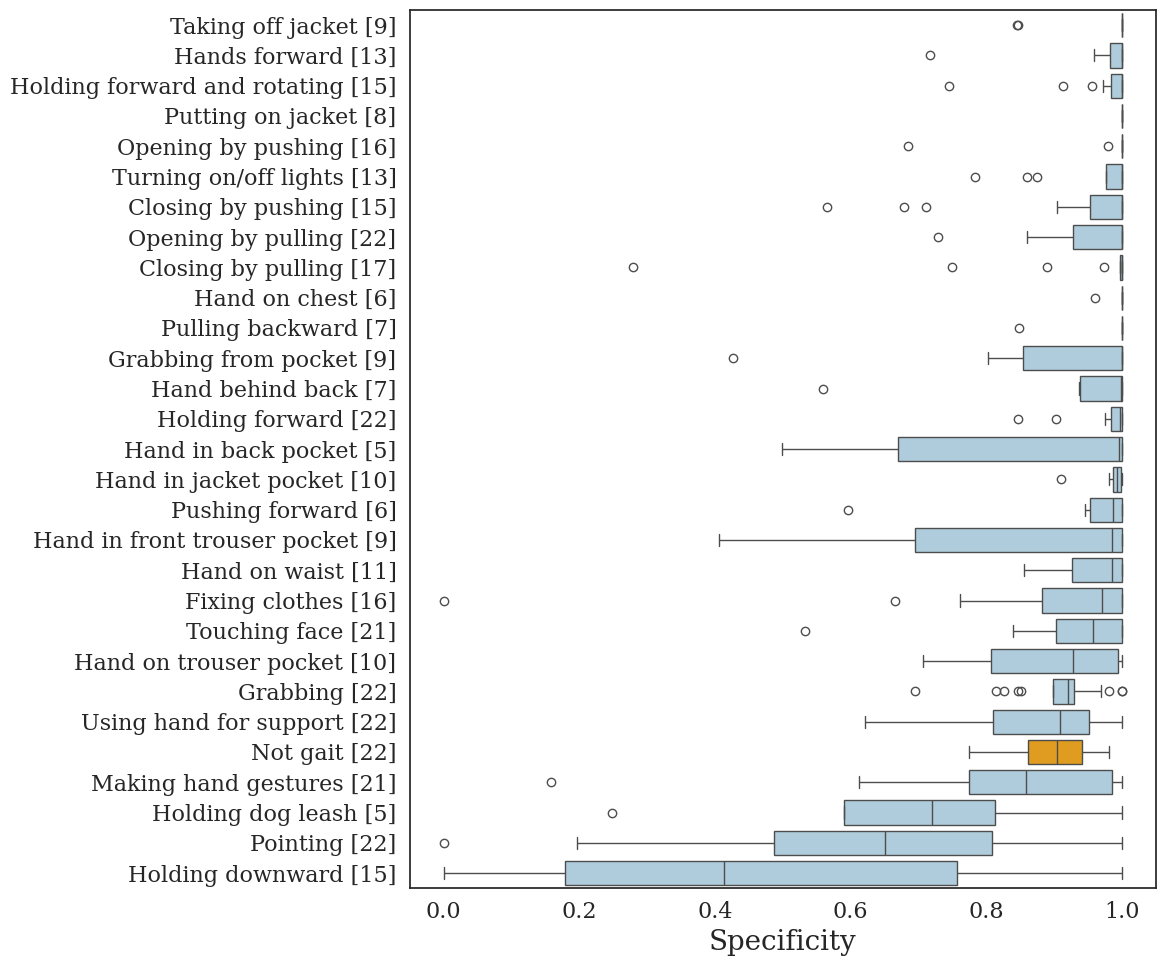

In [12]:
metric = 'spec'
l_arm_activities = list(set([x for y in [list(d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.ARM_ACTIVITY_CLASSIFIER_SELECTED]['arm_activities'].keys()) for x in gc.participant_ids.L_PD_IDS] for x in y]))

d_arm_activity_performance = {}

print("Specificity of arm activities")
for arm_activity in [x for x in l_arm_activities if 'Gait' not in x and 'Walking' not in x and x != 'Transition']:
    l_arm_activity_spec = [
        d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.ARM_ACTIVITY_CLASSIFIER_SELECTED]['arm_activities'][arm_activity][metric] for x in 
        gc.participant_ids.L_PD_IDS if 
        arm_activity in d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.ARM_ACTIVITY_CLASSIFIER_SELECTED]['arm_activities']
    ]
    if len(l_arm_activity_spec) >= 5:
        d_arm_activity_performance[arm_activity] = l_arm_activity_spec

d_arm_activity_performance = {f'{k} [{len(d_arm_activity_performance[k])}]': v for k, v in sorted(d_arm_activity_performance.items(), key=lambda item: np.median(item[1]), reverse=True)}

palette_as = {label: 'orange' if 'Not gait' in label else gc.plot_parameters.COLOR_PALETTE_FIRST_COLOR for label in d_arm_activity_performance.keys()}

fig, ax = plt.subplots(figsize=(12, 10))

sns.boxplot(data=d_arm_activity_performance, ax=ax, palette=palette_as, color=gc.plot_parameters.COLOR_PALETTE_FIRST_COLOR, orient='h')

# plot_n_subjects(d_performance=d_arm_activity_performance, x_loc=1.06, y_loc=1.4, ax=ax)

ax.set_xlabel(mp.metric_map[metric])
# ax.set_ylabel('Arm activity')
# ax.set_title('Sensitivity per arm activity')
plt.tight_layout()
plt.show()

#### Segment duration

Sensitivity per gait segment duration
short: 0.55 +/- 0.16
moderately_long: 0.73 +/- 0.14
long: 0.81 +/- 0.21
very_long: 0.88 +/- 0.24


C:\Users\erik_\AppData\Local\Temp\ipykernel_21056\802124196.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Short\n[$<$5s]', 'Moderately long\n[5-10s]', 'Long\n[10-20s]', 'Very long\n[$>$20s]'])


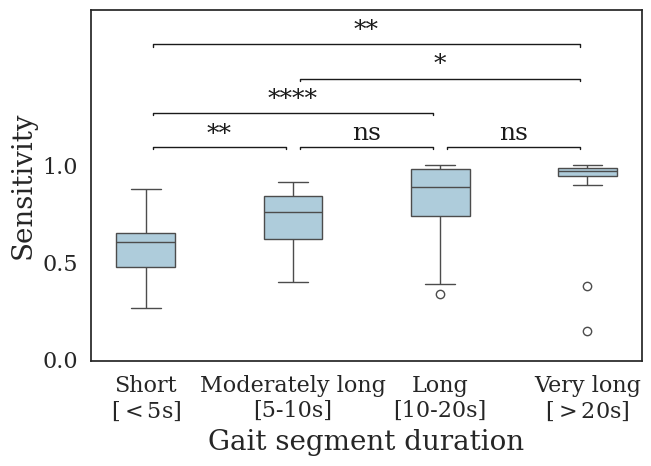

In [13]:
metric = 'sens'
affected_side = gc.descriptives.MOST_AFFECTED_SIDE
pre_or_post = 'pre'

l_ids = [x for x in gc.participant_ids.L_PD_IDS if all([y in d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.ARM_ACTIVITY_CLASSIFIER_SELECTED][affected_side][pre_or_post][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'].keys() for y in l_segment_cats]) and all([~np.isnan(d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.ARM_ACTIVITY_CLASSIFIER_SELECTED][affected_side][pre_or_post][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'][y][metric]) for y in ['short', 'moderately_long', 'long', 'very_long']])]

d_segment_performance= {}

print(f"{mp.metric_map[metric]} per gait segment duration")
for segment_duration in l_segment_cats:
    d_segment_performance[segment_duration] = [d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.ARM_ACTIVITY_CLASSIFIER_SELECTED][affected_side][pre_or_post][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'][segment_duration][metric] for x in l_ids if segment_duration in d_performance[gc.descriptives.PARKINSONS_DISEASE][x][gc.classifiers.ARM_ACTIVITY_CLASSIFIER_SELECTED][affected_side][pre_or_post][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'].keys()]
    
    print(f"{segment_duration}: {np.round(np.nanmean(d_segment_performance[segment_duration]),2)} +/- {np.round(np.nanstd(d_segment_performance[segment_duration]),2)}")

# d_segment_performance = {k: v for k, v in sorted(d_segment_performance.items(), key=lambda item: np.median(item[1]), reverse=False)}

fig, ax = plt.subplots(figsize=(7, 5))

sns.boxplot(data=d_segment_performance, width=0.4, ax=ax, color=gc.plot_parameters.COLOR_PALETTE_FIRST_COLOR)
gap = 0.05

pvalue = calculate_pvalue(d_segment_performance['short'], d_segment_performance['moderately_long'], 'wilcoxon')[1]
plot_significance(ax=ax, x_min=0.05, x_max=0.95, pvalue=pvalue, y_min_significance=1.05, gap=gap, row=1, text_size=d_plot_params['font.size'])

pvalue = calculate_pvalue(d_segment_performance['moderately_long'], d_segment_performance['long'], 'wilcoxon')[1]
plot_significance(ax=ax, x_min=1.05, x_max=1.95, pvalue=pvalue, y_min_significance=1.05, gap=gap, row=1, text_size=d_plot_params['font.size'])

pvalue = calculate_pvalue(d_segment_performance['long'], d_segment_performance['very_long'], 'wilcoxon')[1]
plot_significance(ax=ax, x_min=2.05, x_max=2.95, pvalue=pvalue, y_min_significance=1.05, gap=gap, row=1, text_size=d_plot_params['font.size'])

pvalue = calculate_pvalue(d_segment_performance['short'], d_segment_performance['long'], 'wilcoxon')[1]
plot_significance(ax=ax, x_min=0.05, x_max=1.95, pvalue=pvalue, y_min_significance=1.22, gap=gap, row=1, text_size=d_plot_params['font.size'])

pvalue = calculate_pvalue(d_segment_performance['moderately_long'], d_segment_performance['very_long'], 'wilcoxon')[1]
plot_significance(ax=ax, x_min=1.05, x_max=2.95, pvalue=pvalue, y_min_significance=1.39, gap=gap, row=1, text_size=d_plot_params['font.size'])

pvalue = calculate_pvalue(d_segment_performance['short'], d_segment_performance['very_long'], 'wilcoxon')[1]
plot_significance(ax=ax, x_min=0.05, x_max=2.95, pvalue=pvalue, y_min_significance=1.56, gap=gap, row=1, text_size=d_plot_params['font.size'])

ax.set_ylabel(mp.metric_map[metric])
ax.set_xlabel('Gait segment duration')
ax.set_ylim([-0.01,1.8])
ax.set_xticklabels(['Short\n[$<$5s]', 'Moderately long\n[5-10s]', 'Long\n[10-20s]', 'Very long\n[$>$20s]'])
# ax.set_title('Sensitivity per gait segment duration')

for i in range(1,7):
    ax.yaxis.get_major_ticks()[-1*i].label1.set_visible(False)

plt.tight_layout()
plt.show()

## Effect of PD

#### Pre-med vs post-med specificity

System: uncorrected - p-value: 0.030117511749267578
System: corrected - p-value: 0.2902231216430664


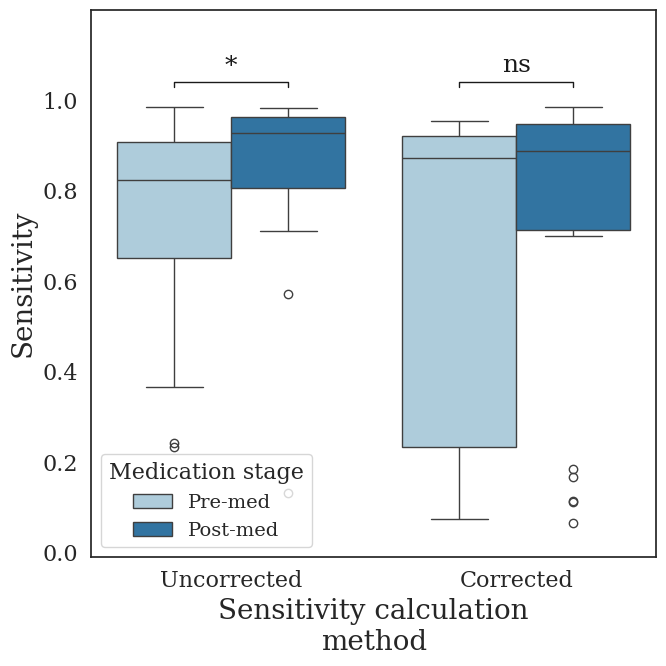

In [14]:
metric = 'sens'
df_segment_duration = pd.DataFrame()
df_uncorrected = pd.DataFrame()

# Collect data for each subject
for subject in gc.participant_ids.L_PD_IDS:
    for med_stage in [gc.descriptives.PRE_MED, gc.descriptives.POST_MED]:
        for segment_duration in mp.segment_rename.keys():
            try:
                d_focus = d_performance[gc.descriptives.PARKINSONS_DISEASE][subject][gc.classifiers.ARM_ACTIVITY_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][med_stage][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'][segment_duration]
            except KeyError:
                continue
            else:
                mins = d_focus['minutes_true']
                metric_val = d_focus[metric]
                df_segment_duration = pd.concat([df_segment_duration, pd.DataFrame([mins, metric_val, segment_duration, subject, med_stage], 
                                            index=['mins', metric, f'{gc.columns.TRUE_SEGMENT_CAT}_duration', gc.columns.ID, gc.columns.PRE_OR_POST]).T])
                
        metric_uncorrected = d_performance[gc.descriptives.PARKINSONS_DISEASE][subject][gc.classifiers.ARM_ACTIVITY_CLASSIFIER_SELECTED][gc.descriptives.MOST_AFFECTED_SIDE][med_stage][metric]
        df_uncorrected = pd.concat([df_uncorrected, pd.DataFrame([metric_uncorrected, subject, med_stage]).T])

df_uncorrected.columns = [metric, gc.columns.ID, gc.columns.PRE_OR_POST]
df_uncorrected['system'] = 'uncorrected'

# Calculate corrected sensitivities
df_corrected_metric = df_segment_duration.copy()

# Calculate corrected prevalence
df_corrected_prevalence = df_segment_duration.groupby(f'{gc.columns.TRUE_SEGMENT_CAT}_duration')['mins'].sum().reset_index()
df_corrected_prevalence['prop_corrected'] = df_corrected_prevalence['mins'] / df_corrected_prevalence['mins'].sum()

# Merge corrected prevalence into corrected sensitivities
df_corrected = df_corrected_metric.merge(df_corrected_prevalence[[f'{gc.columns.TRUE_SEGMENT_CAT}_duration', 'prop_corrected']], 
                                            how='left', 
                                            on=[f'{gc.columns.TRUE_SEGMENT_CAT}_duration'])

# Initialize dataframe containing corrected and uncorrected values
df_complete = pd.DataFrame()

# Calculate sensitivity for the corrected method
for stage in ['pre', 'post']:
    df_stage = df_corrected.loc[df_corrected[gc.columns.PRE_OR_POST] == stage]
    for subject in gc.participant_ids.L_PD_IDS:
        df_subject = df_stage.loc[df_stage[gc.columns.ID] == subject]
        if df_subject.shape[0] > 0:
            # Uncorrected sensitivities
            uncorrected_metric = df_uncorrected.loc[(df_uncorrected[gc.columns.PRE_OR_POST] == stage) & (df_uncorrected[gc.columns.ID] == subject), metric].values
            uncorrected_entry = pd.DataFrame([[stage, subject, 'uncorrected', np.mean(uncorrected_metric) if uncorrected_metric.size > 0 else 0]], 
                                       columns=[gc.columns.PRE_OR_POST, gc.columns.ID, 'system', metric])
            df_complete = pd.concat([df_complete, uncorrected_entry], ignore_index=True)

            # Corrected sensitivity calculation
            corrected_metric = np.sum(np.multiply(df_subject[metric], df_subject['prop_corrected']))
            corrected_entry = pd.DataFrame([[stage, subject, 'corrected', corrected_metric]], 
                                           columns=[gc.columns.PRE_OR_POST, gc.columns.ID, 'system', metric])
            df_complete = pd.concat([df_complete, corrected_entry], ignore_index=True)

# Set column names for df_corrected
df_complete.columns = [gc.columns.PRE_OR_POST, gc.columns.ID, 'system', metric]

# Drop IDs that are missing either pre or post
l_drop_ids = [x for x in df_complete.loc[df_complete[gc.columns.PRE_OR_POST] == 'pre', gc.columns.ID].unique() if x not in df_complete.loc[df_complete[gc.columns.PRE_OR_POST] == 'post', gc.columns.ID].unique()]
df_complete = df_complete.loc[~df_complete[gc.columns.ID].isin(l_drop_ids)]

# Plotting
fig, ax = plt.subplots(figsize=(7,7))

# Define the order for systems
order = ['uncorrected', 'corrected']

sns.boxplot(data=df_complete, x='system', y=metric, hue=gc.columns.PRE_OR_POST, order=order, palette=gc.plot_parameters.COLOR_PALETTE)

for j, system in enumerate(order):
    vals_pre = list(df_complete.loc[(df_complete['system'] == system) & (df_complete[gc.columns.PRE_OR_POST] == 'pre'), metric].values)
    vals_post = list(df_complete.loc[(df_complete['system'] == system) & (df_complete[gc.columns.PRE_OR_POST] == 'post'), metric].values)

    # Assuming calculate_pvalue and plot_significance are functions already defined
    pvalue = calculate_pvalue(vals_pre, vals_post, 'wilcoxon')[1]
    plot_significance(ax=ax, x_min=j + 0.2, x_max=j - 0.2, pvalue=pvalue, y_min_significance=1, gap=0.01, row=1, text_size=d_plot_params['font.size'])

    print(f"System: {system} - p-value: {pvalue}")

ax.set_ylim([-0.01, 1.2])
ax.set_xticks(ax.get_xticks(), ['Uncorrected', 'Corrected'])
# ax.set_title('Sensitivity with and without correction')
ax.set_xlabel('Sensitivity calculation\nmethod')
ax.set_ylabel('Sensitivity')

# Customize legend and axis tick visibility
ax.legend(handles=ax.get_legend_handles_labels()[0], labels=['Pre-med', 'Post-med'], title='Medication stage', loc='lower left')

for j in range(1, 2):
    ax.yaxis.get_major_ticks()[-1 * j].label1.set_visible(False)

fig.tight_layout()
plt.show()

#### Pre-med MAS vs LAS

System: uncorrected - p-value: 0.6556386947631836
System: corrected - p-value: 0.8485937118530273


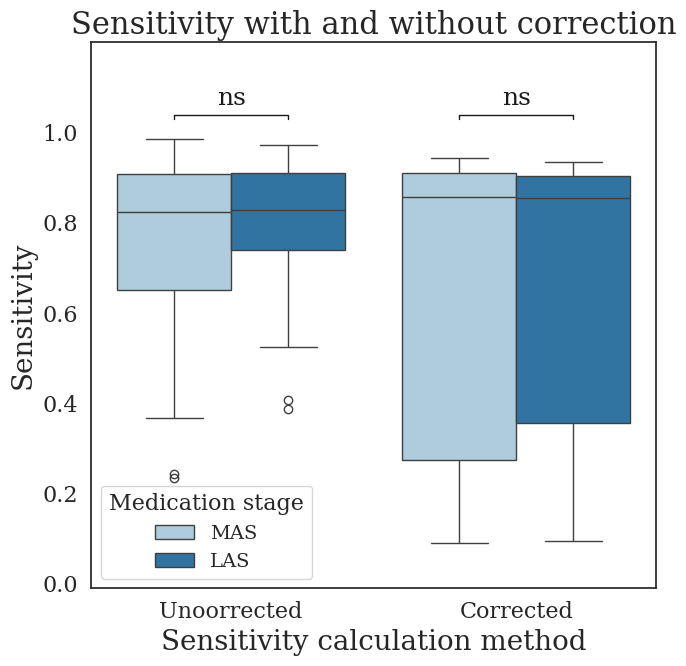

In [15]:
metric = 'sens'
med_stage = 'pre'
df_segment_duration = pd.DataFrame()
df_uncorrected = pd.DataFrame()

# Collect data for each subject
for subject in gc.participant_ids.L_PD_IDS:
    for side in [gc.descriptives.MOST_AFFECTED_SIDE, gc.descriptives.LEAST_AFFECTED_SIDE]:
        for segment_duration in mp.segment_rename.keys():
            try:
                d_focus = d_performance[gc.descriptives.PARKINSONS_DISEASE][subject][gc.classifiers.ARM_ACTIVITY_CLASSIFIER_SELECTED][side][med_stage][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'][segment_duration]
            except KeyError:
                continue
            else:
                mins = d_focus['minutes_true']
                metric_val = d_focus[metric]
                df_segment_duration = pd.concat([df_segment_duration, pd.DataFrame([mins, metric_val, segment_duration, subject, side], 
                                            index=['mins', metric, f'{gc.columns.TRUE_SEGMENT_CAT}_duration', gc.columns.ID, gc.columns.SIDE]).T])
                
        metric_uncorrected = d_performance[gc.descriptives.PARKINSONS_DISEASE][subject][gc.classifiers.ARM_ACTIVITY_CLASSIFIER_SELECTED][side][med_stage][metric]
        df_uncorrected = pd.concat([df_uncorrected, pd.DataFrame([metric_uncorrected, subject, side]).T])

df_uncorrected.columns = [metric, gc.columns.ID, gc.columns.SIDE]
df_uncorrected['system'] = 'uncorrected'

# Calculate corrected sensitivities
df_corrected_metric = df_segment_duration.copy()

# Calculate corrected prevalence
df_corrected_prevalence = df_segment_duration.groupby(f'{gc.columns.TRUE_SEGMENT_CAT}_duration')['mins'].sum().reset_index()
df_corrected_prevalence['prop_corrected'] = df_corrected_prevalence['mins'] / df_corrected_prevalence['mins'].sum()

# Merge corrected prevalence into corrected sensitivities
df_corrected = df_corrected_metric.merge(df_corrected_prevalence[[f'{gc.columns.TRUE_SEGMENT_CAT}_duration', 'prop_corrected']], 
                                            how='left', 
                                            on=[f'{gc.columns.TRUE_SEGMENT_CAT}_duration'])

# Initialize dataframe containing corrected and uncorrected values
df_complete = pd.DataFrame()

# Calculate sensitivity for the corrected method
for side in [gc.descriptives.MOST_AFFECTED_SIDE, gc.descriptives.LEAST_AFFECTED_SIDE]:
    df_side = df_corrected.loc[df_corrected[gc.columns.SIDE] == side]
    for subject in gc.participant_ids.L_PD_IDS:
        df_subject = df_side.loc[df_side[gc.columns.ID] == subject]
        if df_subject.shape[0] > 0:
            # Uncorrected sensitivities
            uncorrected_metric = df_uncorrected.loc[(df_uncorrected[gc.columns.SIDE] == side) & (df_uncorrected[gc.columns.ID] == subject), metric].values
            uncorrected_entry = pd.DataFrame([[side, subject, 'uncorrected', np.mean(uncorrected_metric) if uncorrected_metric.size > 0 else 0]], 
                                       columns=[gc.columns.SIDE, gc.columns.ID, 'system', metric])
            df_complete = pd.concat([df_complete, uncorrected_entry], ignore_index=True)

            # Corrected sensitivity calculation
            corrected_metric = np.sum(np.multiply(df_subject[metric], df_subject['prop_corrected']))
            corrected_entry = pd.DataFrame([[side, subject, 'corrected', corrected_metric]], 
                                           columns=[gc.columns.SIDE, gc.columns.ID, 'system', metric])
            df_complete = pd.concat([df_complete, corrected_entry], ignore_index=True)

# Set column names for df_corrected
df_complete.columns = [gc.columns.SIDE, gc.columns.ID, 'system', metric]

# Drop IDs that are missing either pre or post
l_drop_ids = [x for x in df_complete.loc[df_complete[gc.columns.SIDE] == gc.descriptives.MOST_AFFECTED_SIDE, gc.columns.ID].unique() if x not in df_complete.loc[df_complete[gc.columns.SIDE] == gc.descriptives.LEAST_AFFECTED_SIDE, gc.columns.ID].unique()]
df_complete = df_complete.loc[~df_complete[gc.columns.ID].isin(l_drop_ids)]

# Plotting
fig, ax = plt.subplots(figsize=(7,7))

# Define the order for systems
order = ['uncorrected', 'corrected']

sns.boxplot(data=df_complete, x='system', y=metric, hue=gc.columns.SIDE, order=order, palette=gc.plot_parameters.COLOR_PALETTE)

for j, system in enumerate(order):
    vals_mas = list(df_complete.loc[(df_complete['system'] == system) & (df_complete[gc.columns.SIDE] == gc.descriptives.MOST_AFFECTED_SIDE), metric].values)
    vals_las = list(df_complete.loc[(df_complete['system'] == system) & (df_complete[gc.columns.SIDE] == gc.descriptives.LEAST_AFFECTED_SIDE), metric].values)

    # Assuming calculate_pvalue and plot_significance are functions already defined
    pvalue = calculate_pvalue(vals_mas, vals_las, 'wilcoxon')[1]
    plot_significance(ax=ax, x_min=j + 0.2, x_max=j - 0.2, pvalue=pvalue, y_min_significance=1, gap=0.01, row=1, text_size=d_plot_params['font.size'])

    print(f"System: {system} - p-value: {pvalue}")

ax.set_ylim([-0.01, 1.2])
ax.set_xticks(ax.get_xticks(), ['Unoorrected', 'Corrected'])
ax.set_title('Sensitivity with and without correction')
ax.set_xlabel('Sensitivity calculation method')
ax.set_ylabel('Sensitivity')

# Customize legend and axis tick visibility
ax.legend(handles=ax.get_legend_handles_labels()[0], labels=['MAS', 'LAS'], title='Medication stage')

for j in range(1, 2):
    ax.yaxis.get_major_ticks()[-1 * j].label1.set_visible(False)

fig.tight_layout()
plt.show()

#### Correlation MDS-UPDRS

Very long [> 20s] segments: r = -0.48 95% CI [-0.77884053  0.00524751], p = 0.0530841931079915


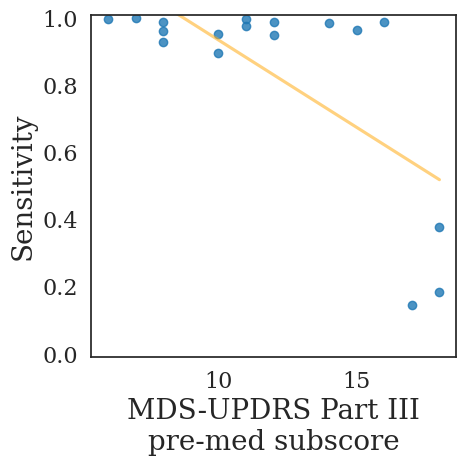

In [16]:
metric = 'sens'

fig, ax = plt.subplots(figsize=(5,5))

affected_side = 'MAS'
med_stage = 'pre'
segment_duration = 'very_long'

df_segment_clinical = pd.DataFrame()

for subject in gc.participant_ids.L_PD_IDS:
    if segment_duration in d_performance[gc.descriptives.PARKINSONS_DISEASE][subject][gc.classifiers.ARM_ACTIVITY_CLASSIFIER_SELECTED][affected_side][med_stage][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'].keys():
        df_segment_clinical = pd.concat([
            df_segment_clinical, 
            pd.DataFrame([subject, d_performance[gc.descriptives.PARKINSONS_DISEASE][subject][gc.classifiers.ARM_ACTIVITY_CLASSIFIER_SELECTED][affected_side][med_stage][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'][segment_duration]['minutes_true'], 
                            d_performance[gc.descriptives.PARKINSONS_DISEASE][subject][gc.classifiers.ARM_ACTIVITY_CLASSIFIER_SELECTED][affected_side][med_stage][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'][segment_duration][metric], 
                            d_performance[gc.descriptives.PARKINSONS_DISEASE][subject]['clinical']['updrs'][med_stage][affected_side]['total'], d_performance[gc.descriptives.PARKINSONS_DISEASE][subject]['clinical']['updrs'][med_stage][affected_side]['subscore']
                            ]).T
            ])
        
df_segment_clinical.columns = [gc.columns.ID, 'minutes_true', metric, 'total', 'subscore']

df_segment_clinical['minutes_true'] = df_segment_clinical['minutes_true'].astype(float)
df_segment_clinical[metric] = df_segment_clinical[metric].astype(float)
df_segment_clinical['total'] = df_segment_clinical['total'].astype(float)
df_segment_clinical['subscore'] = df_segment_clinical['subscore'].astype(float)

df_segment_clinical = df_segment_clinical.loc[(df_segment_clinical[metric].notna())]
# df_segment_clinical = df_segment_clinical.loc[(df_segment_clinical[metric].notna()) & (df_segment_clinical['minutes_true']>=d_min_lengths[segment_duration]/60)]

sns.regplot(x='subscore', y=metric, data=df_segment_clinical, ci=False, scatter_kws={'color': gc.plot_parameters.COLOR_PALETTE_SECOND_COLOR}, line_kws={'color': 'orange', 'alpha': 0.5}, marker='o', label='PD patient', ax=ax)
rho = spearmanr(df_segment_clinical[metric], df_segment_clinical['subscore']).statistic
rho_p = spearmanr(df_segment_clinical[metric], df_segment_clinical['subscore']).pvalue

zr = np.log((1+rho)/(1-rho))/2
lower = zr - 1.96/np.sqrt(len(df_segment_clinical)-3)
upper = zr + 1.96/np.sqrt(len(df_segment_clinical)-3)

ci = np.tanh(np.array([lower, upper]))

print(f"{mp.segment_rename[segment_duration].replace('$', '')} segments: r = {np.round(rho,2)} 95% CI {ci}, p = {rho_p}")

# ax.set_title(mp.segment_rename[segment_duration])
ax.set_ylabel(mp.metric_map[metric])
ax.set_xlabel('MDS-UPDRS Part III\npre-med subscore')
ax.set_ylim([-.01,1.01])

fig.tight_layout()

plt.show()

Short [< 5s] segments: r = -0.16 95% CI [-0.54731443  0.27731454], p = 0.46746488111915974
Moderately long [5-10s] segments: r = -0.39 95% CI [-0.69550259  0.04075114], p = 0.07476212357425382
Long [10-20s] segments: r = -0.61 95% CI [-0.83189988 -0.21105434], p = 0.005844606485528429
Very long [> 20s] segments: r = -0.48 95% CI [-0.77884053  0.00524751], p = 0.0530841931079915


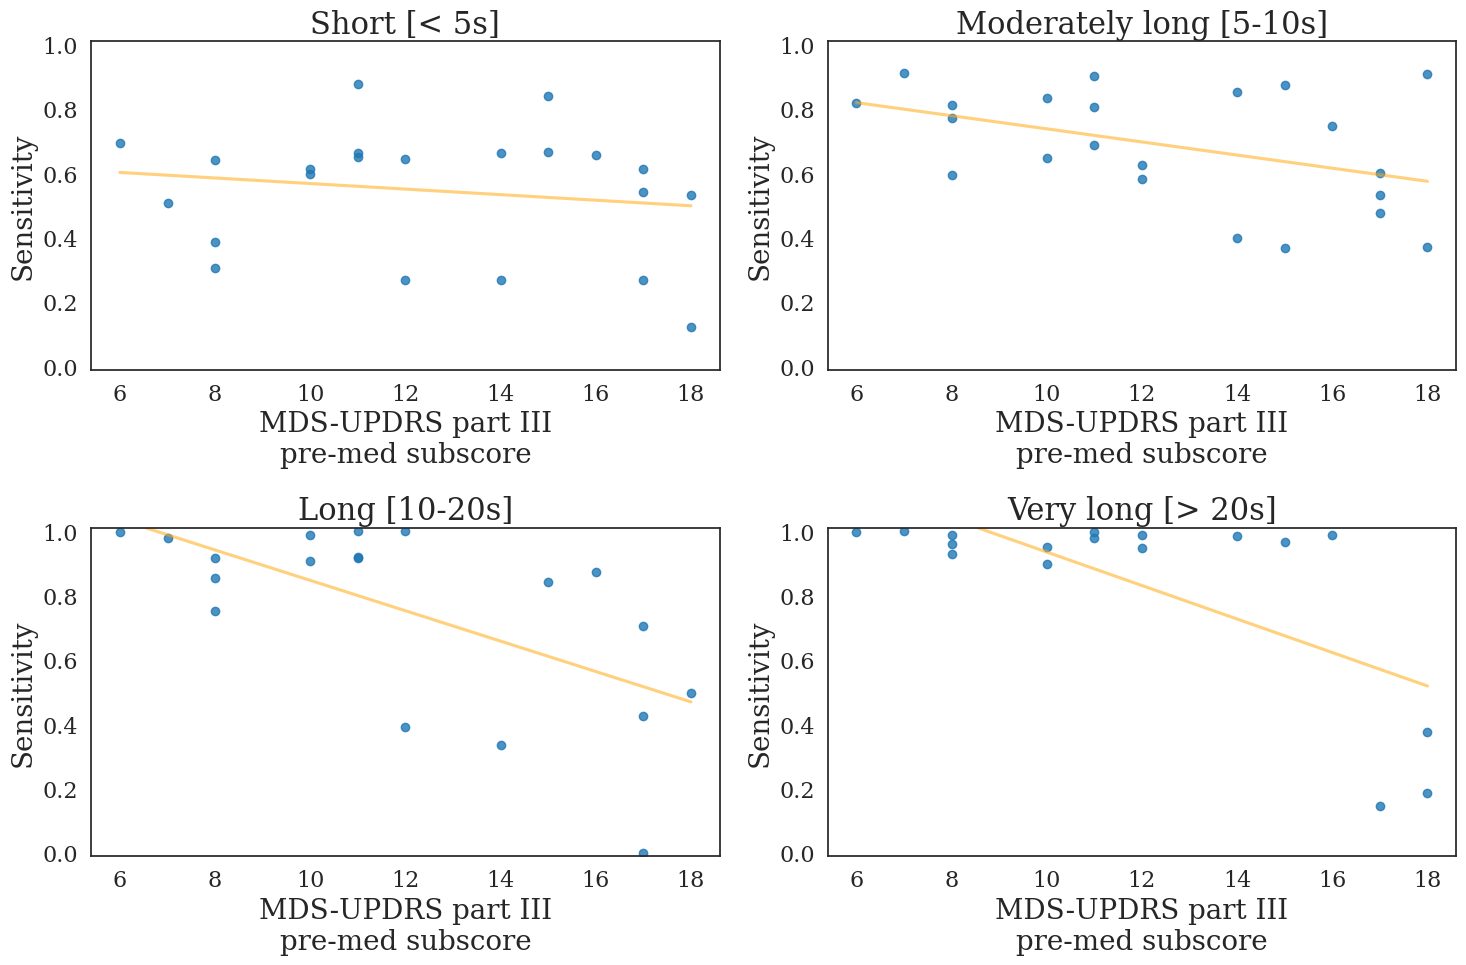

In [17]:
metric = 'sens'

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

affected_side = 'MAS'
med_stage = 'pre'

for j, segment_duration in enumerate(mp.segment_rename.keys()):
    df_segment_clinical = pd.DataFrame()

    for subject in gc.participant_ids.L_PD_IDS:
        if segment_duration in d_performance[gc.descriptives.PARKINSONS_DISEASE][subject][gc.classifiers.ARM_ACTIVITY_CLASSIFIER_SELECTED][affected_side][med_stage][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'].keys():
            df_segment_clinical = pd.concat([
                df_segment_clinical, 
                pd.DataFrame([subject, d_performance[gc.descriptives.PARKINSONS_DISEASE][subject][gc.classifiers.ARM_ACTIVITY_CLASSIFIER_SELECTED][affected_side][med_stage][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'][segment_duration]['minutes_true'], 
                              d_performance[gc.descriptives.PARKINSONS_DISEASE][subject][gc.classifiers.ARM_ACTIVITY_CLASSIFIER_SELECTED][affected_side][med_stage][f'{gc.columns.TRUE_SEGMENT_CAT}_duration'][segment_duration][metric], 
                              d_performance[gc.descriptives.PARKINSONS_DISEASE][subject]['clinical']['updrs'][med_stage][affected_side]['total'], d_performance[gc.descriptives.PARKINSONS_DISEASE][subject]['clinical']['updrs'][med_stage][affected_side]['subscore']
                              ]).T
                ])
            
    df_segment_clinical.columns = [gc.columns.ID, 'minutes_true', metric, 'total', 'subscore']

    df_segment_clinical['minutes_true'] = df_segment_clinical['minutes_true'].astype(float)
    df_segment_clinical[metric] = df_segment_clinical[metric].astype(float)
    df_segment_clinical['total'] = df_segment_clinical['total'].astype(float)
    df_segment_clinical['subscore'] = df_segment_clinical['subscore'].astype(float)

    df_segment_clinical = df_segment_clinical.loc[(df_segment_clinical[metric].notna())]
    # df_segment_clinical = df_segment_clinical.loc[(df_segment_clinical[metric].notna()) & (df_segment_clinical['minutes_true']>=d_min_lengths[segment_duration]/60)]

    sns.regplot(x='subscore', y=metric, data=df_segment_clinical, ci=False, scatter_kws={'color': gc.plot_parameters.COLOR_PALETTE_SECOND_COLOR}, line_kws={'color': 'orange', 'alpha': 0.5}, marker='o', label='PD patient', ax=ax[j//2,j%2])
    rho = spearmanr(df_segment_clinical[metric], df_segment_clinical['subscore']).statistic
    rho_p = spearmanr(df_segment_clinical[metric], df_segment_clinical['subscore']).pvalue

    zr = np.log((1+rho)/(1-rho))/2
    lower = zr - 1.96/np.sqrt(len(df_segment_clinical)-3)
    upper = zr + 1.96/np.sqrt(len(df_segment_clinical)-3)

    ci = np.tanh(np.array([lower, upper]))

    print(f"{mp.segment_rename[segment_duration].replace('$', '')} segments: r = {np.round(rho,2)} 95% CI {ci}, p = {rho_p}")

    ax[j//2,j%2].set_title(mp.segment_rename[segment_duration])
    ax[j//2,j%2].set_ylabel(mp.metric_map[metric])
    ax[j//2,j%2].set_xlabel('MDS-UPDRS part III\npre-med subscore')
    ax[j//2,j%2].set_ylim([-.01,1.01])

fig.tight_layout()

plt.show()

In [18]:
df_segment_clinical

,id,minutes_true,sens,total,subscore
0,hbv002,9.506833,0.929559,11.0,8.0
0,hbv012,0.920000,0.896739,18.0,10.0
0,hbv014,6.474333,0.987618,14.0,12.0
0,hbv016,0.510000,0.987255,10.0,8.0
0,hbv017,1.215167,0.185160,25.0,18.0
0,hbv022,7.808500,0.960022,12.0,8.0
0,hbv024,5.643833,0.144169,26.0,17.0
0,hbv043,5.260167,0.948322,13.0,12.0
0,hbv047,1.939000,0.989084,19.0,16.0
0,hbv065,2.136833,0.951330,13.0,10.0


## Supplementary materials

#### Stratified performance

In [64]:
gd_model_selected = gc.classifiers.RANDOM_FOREST

d_performance_gd = {}
for subject in gc.participant_ids.L_PD_IDS:
    with open(os.path.join(gc.paths.PATH_OUTPUT, 'classification_performance', 'gait', f'{subject}.json'), 'r') as f:
        d_performance_gd[subject] = json.load(f)

In [65]:
df_subject_results = pd.DataFrame()
affected_side = gc.descriptives.MOST_AFFECTED_SIDE

for subject in gc.participant_ids.L_PD_IDS:
    for med_stage in ['pre', 'post']:
        for metric in ['sens', 'spec']:
            df_subject = pd.DataFrame([subject,
                                       'Gait detection',
                                       med_stage,
                                       metric,
                                       np.round(d_performance_gd[subject][gd_model_selected][affected_side][med_stage][metric],2),
                                        ]).T

            df_subject_results = pd.concat([df_subject_results, df_subject], axis=0).reset_index(drop=True)

            df_subject = pd.DataFrame([subject,
                                       'Filtering gait',
                                       med_stage,
                                       metric,
                                       np.round(d_performance[gc.descriptives.PARKINSONS_DISEASE][subject][gc.classifiers.ARM_ACTIVITY_CLASSIFIER_SELECTED][affected_side][med_stage][metric],2),
                                        ]).T
            
            df_subject_results = pd.concat([df_subject_results, df_subject], axis=0).reset_index(drop=True)


df_subject_results.columns = [gc.columns.ID, 'method', 'med_stage', 'metric', 'value']

print("Table 2: Sensitivity (sens) and specificity (spec) of gait detection and filtering gait per PD participant (ID)")
df_subject_results.pivot_table(index=gc.columns.ID, columns=['method', 'med_stage', 'metric'], values='value')

Table 2: Sensitivity (sens) and specificity (spec) of gait detection and filtering gait per PD participant (ID)


method    Filtering gait                   Gait detection                  
med_stage           post         pre                 post         pre      
metric              sens  spec  sens  spec           sens  spec  sens  spec
id                                                                         
hbv002              0.92  0.95  0.85  0.91           0.94  0.95  0.88  0.96
hbv012              0.96  0.62  0.97  0.73           0.85   0.9  0.84  0.89
hbv013              0.84  0.96  0.91  0.53           0.87  0.94  0.68  0.97
hbv014              0.96  0.93  0.83  0.88           0.96  0.96  0.95  0.95
hbv015              0.96  0.68  0.91  0.13           0.98  0.89  0.87  0.93
hbv016              0.79  0.85  0.91  0.61           0.94  0.95  0.92  0.95
hbv017              0.99  0.17  0.99   0.2           0.95  0.96  0.85  0.94
hbv018              0.98  0.49   0.9   0.6           0.96  0.89  0.97  0.89
hbv022              0.93  0.91  0.93  0.85           0.96  0.87  0.93  0.98
hbv023              0.82  0.91   0.9  0.88           0.99  0.91  0.96  0.93
hbv024              0.88  0.81  0.89  0.23           0.97  0.96  0.94  0.96
hbv038              0.64  0.75  0.94  0.49           0.96  0.87  0.59  0.95
hbv039              0.96  0.84  0.98  0.34           0.99  0.96  0.95  0.97
hbv043              0.92  0.78  0.83  0.78           0.96  0.96  0.89  0.96
hbv047              0.83  0.91  0.93   0.8           0.94  0.95  0.86  0.91
hbv054              0.96  0.52  0.96  0.69            0.8  0.95  0.78  0.96
hbv058              0.94  0.98  0.99  0.89           0.97  0.96  0.89  0.98
hbv063              0.87  0.97  0.94  0.95           0.94  0.88  0.89  0.94
hbv065               0.9  0.72  0.88  0.78            0.9  0.97  0.93  0.96
hbv077               0.9  0.98  0.85  0.97           0.99  0.78  0.98  0.96
hbv079              0.88  0.96  0.84  0.94           0.97  0.86  0.94  0.91
hbv090               0.9  0.98  0.92  0.97           0.99  0.83  0.96  0.96